# Analyze network balance with frustration index an algebraic conflict

In [2]:
import networkx as nx
import pandas as pd
from matplotlib import pyplot as plt
import tqdm
import os
from tqdm import tqdm
import glob
import re

import sys
sys.path.append('../local/bin/')

from sygno.signed_networkx import draw_signed_networkx

____________________

Retrieve Clausen and Peltzman categories

In [3]:
congress_path = '../dataset/download_votes_merged/*'

In [4]:
# Initialize a weighted bipartite graph
G = nx.Graph()

# Iterate through each CSV file
for csv_file in tqdm(glob.glob(congress_path)):
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(csv_file)
    
    # Count the occurrences of each pair of Clausen and Peltzman categories
    counts = df.groupby(["Clausen", "Peltzman"]).size().reset_index(name="count")
    
    # Add edges to the graph with weights based on the counts
    for _, row in counts.iterrows():
        clausen_category = row["Clausen"]
        peltzman_category = row["Peltzman"]
        count = row["count"]
        
        G.add_node(clausen_category, bipartite=0)
        G.add_node(peltzman_category, bipartite=1)
        G.add_edge(clausen_category, peltzman_category, weight=count)

# Now you have a weighted bipartite graph (G) with edges representing the co-occurrences
# between Clausen and Peltzman categories and weights representing the number of occurrences.

  0%|          | 0/41 [00:00<?, ?it/s]

 78%|███████▊  | 32/41 [00:39<00:12,  1.35s/it]/tmp/ipykernel_32470/3165551236.py:7: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file)
100%|██████████| 41/41 [00:56<00:00,  1.39s/it]


In [5]:
print('Clausen categories: ', [n for n in G.nodes() if G.nodes[n]['bipartite'] == 0])
print('Number of Clausen categories: ', len([n for n in G.nodes() if G.nodes[n]['bipartite'] == 0]))

print('Peltzman categories: ', [n for n in G.nodes() if G.nodes[n]['bipartite'] == 1])
print('Number of Peltzman categories: ', len([n for n in G.nodes() if G.nodes[n]['bipartite'] == 1]))

Clausen categories:  ['Agriculture', 'Civil Liberties', 'Foreign and Defense Policy', 'Government Management', 'Miscellaneous Policy', 'Social Welfare']
Number of Clausen categories:  6
Peltzman categories:  ['Budget Special Interest', 'Regulation General Interest', 'Regulation Special Interest', 'Domestic Social Policy', 'Defense Policy Budget', 'Defense Policy Resolutions', 'Foreign Policy Budget', 'Foreign Policy Resolutions', 'Budget General Interest', 'D. C.', 'Government Organization', 'Indian Affairs', 'Internal Organization']
Number of Peltzman categories:  13


In [6]:
clausen_cat_list = [n for n in G.nodes() if G.nodes[n]['bipartite'] == 0]
peltzman_cat_list = [n for n in G.nodes() if G.nodes[n]['bipartite'] == 1]

In [7]:
clausen_cat_dic = {x: re.sub(' ', '_', x) for x in clausen_cat_list}
peltzman_cat_dic = {x: re.sub(' ', '_', x) for x in peltzman_cat_list}

_________________________

In [8]:
dataset_folder = '../dataset/'

Load the dataframe created in the *data_parsing.ipynb* containing all the information about the members of the congresses

In [9]:
pol = pd.read_csv(dataset_folder + 'members.csv')
pol['color'] = pol['party_name'].apply(lambda x: 'firebrick' if 'Republican' in x else ('royalblue' if 'Democrat' in x else 'yellow'))
pol.head()

,icpsr,congress,party_code,bioname,state_abbrev,party_name,color
0,1,[82],[200],"AANDAHL, Fred George",ND,['Republican'],firebrick
1,2,"[80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 9...",[100],"ABBITT, Watkins Moorman",VA,['Democrat'],royalblue
2,3,"[28, 29, 30]",[29],"ABBOTT, Amos",MA,['Whig'],yellow
3,4,"[50, 51, 52, 53, 54]",[100],"ABBOTT, Jo (Joseph)",TX,['Democrat'],royalblue
4,5,"[15, 16, 17, 18]","[7777, 13]","ABBOT, Joel",GA,"['Crawford Republican', 'Democrat-Republican']",firebrick


Create a dictionary that links each icpsr to a party. Notice that an icpsr identifies uniquely a legislator, but a legislator can have more than one icpsr. This is because the icpsr is assigned to a legislator for each congress. For example, if a legislator is elected in 2000 and reelected in 2002, he will have two different icpsr, one for each congress. We will use the icpsr of the first congress in which the legislator was elected.

In [10]:
pol_dic = pol[['icpsr', 'party_name']].set_index('icpsr').to_dict(orient="index")
# e.g.
pol_dic[323]

{'party_name': "['Democrat-Republican']"}

In [11]:
def draw_graph(df, pol_dic):

    # Arguments:
	# df ---> edgelist
	# pol_dic ---> dictionary where key is icpsr and value is party_name
	# congress_num ---> congress number


    G = nx.from_pandas_edgelist(df, 'source', 'target', ['weight'])

    nodeData = {list(g.icpsr)[0]: {'state': list(g.state_abbrev)[0], 'party': list(g.party_name)[0], 'color': list(g.color)[0],  'congress': list(g.congress)[0], 'name': list(g.bioname)[0]} for k, g in pol.groupby('icpsr')}
    nx.set_node_attributes(G, nodeData)

    colors = [node[1]['color'] for node in G.nodes(data=True)]
    
    fig, ax, pos, least_eigenvalue = draw_signed_networkx(G, node_color=colors, compact = True, theme="white", normalize=True, scale='log', jittering=0.01, margin=0.2, show_rotation=False, highlight_edges='frustrated', remove_n_outliers=3, sort_by='party')
    
    # print infos about users per party
    positions_party = {'pos': {'Democrat': 0,'Republican':0}, 'neg': {'Democrat': 0,'Republican':0}}
    for p in pos.keys():
        if pos[p].x > 0:
            if pol_dic[int(p)]['party_name'] == 'Democrat' or pol_dic[int(p)]['party_name'] == 'Republican':
                positions_party['pos'][pol_dic[int(p)]['party_name']] += 1
        else:
            if pol_dic[int(p)]['party_name'] == 'party_name' or pol_dic[int(p)]['party_name'] == 'Republican':
                positions_party['neg'][pol_dic[int(p)]['party_name']] += 1

    plt.text(0, .04, "Rep: "+str(positions_party['neg']['Republican']), fontsize=13, transform=ax.transAxes, color="ghostwhite")
    plt.text(0, .09, "Dem: "+str(positions_party['neg']['Democrat']), fontsize=13, transform=ax.transAxes, color="ghostwhite")

    plt.text(0.9, .04, "Rep: "+str(positions_party['pos']['Republican']), fontsize=13, transform=ax.transAxes, color="ghostwhite")
    plt.text(0.9, .09, "Dem: "+str(positions_party['pos']['Democrat']), fontsize=13, transform=ax.transAxes, color="ghostwhite")
    

    plt.show()

    return least_eigenvalue

In [12]:
def read_edgelist(folder, threshold_pos, threshold_neg):
    # read edgelist
    df = pd.read_csv(folder)
    df_pos = df.loc[(df['weight']==1)&(df['perc']>threshold_pos)].copy()
    df_neg = df.loc[(df['weight']==-1)&(df['perc']>threshold_neg)].copy()
    df = pd.concat([df_pos, df_neg])
    

    least_eigen = draw_graph(df, pol_dic)

    return least_eigen

In [13]:
thresholds_path = '../dataset/thresholds/'
edgelists_path = '../dataset/edgelists/'

In [20]:
eigenvalues = {}

  0%|          | 0/37 [00:00<?, ?it/s]

86


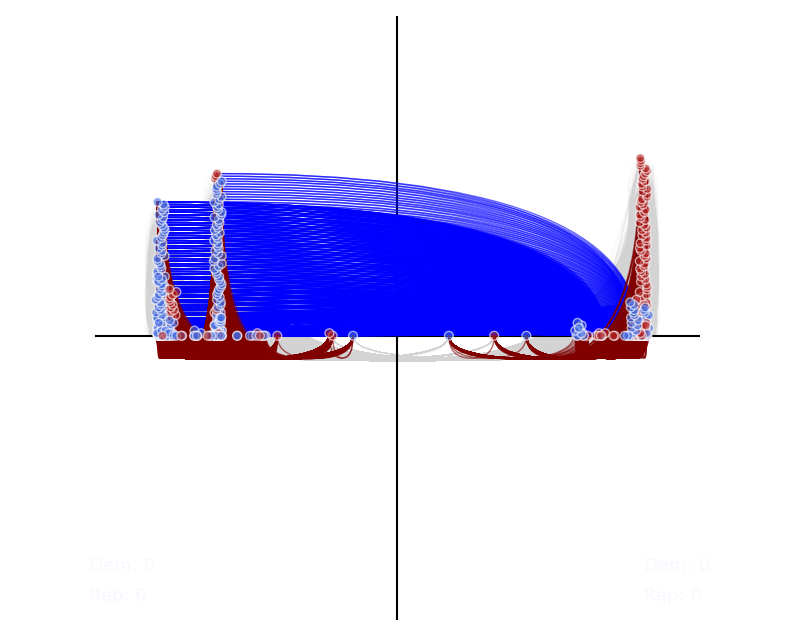

  3%|▎         | 1/37 [00:21<12:41, 21.16s/it]

80


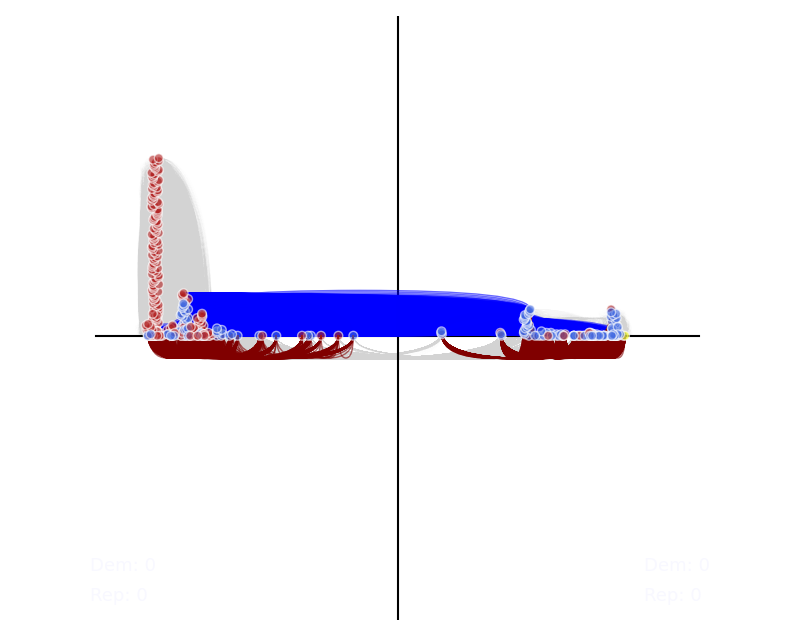

  5%|▌         | 2/37 [00:40<11:41, 20.06s/it]

90


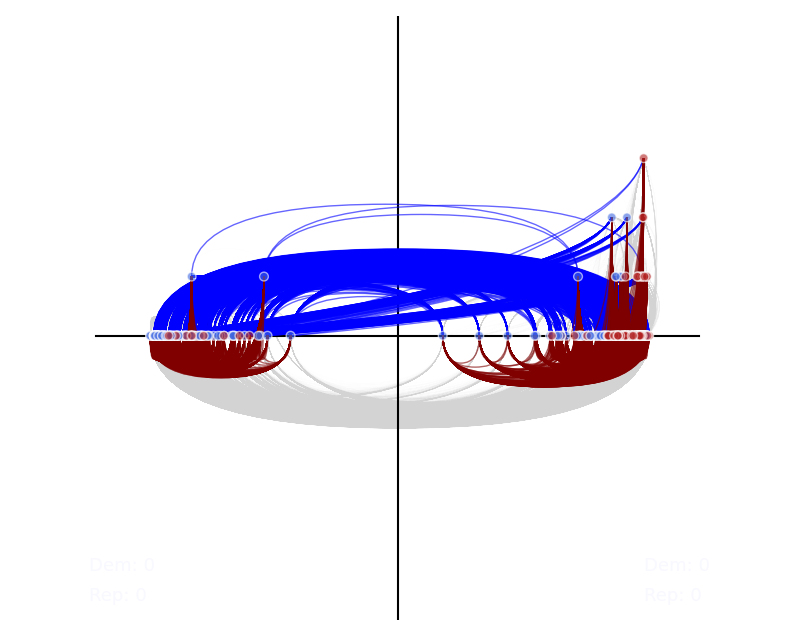

  8%|▊         | 3/37 [01:00<11:24, 20.15s/it]

102


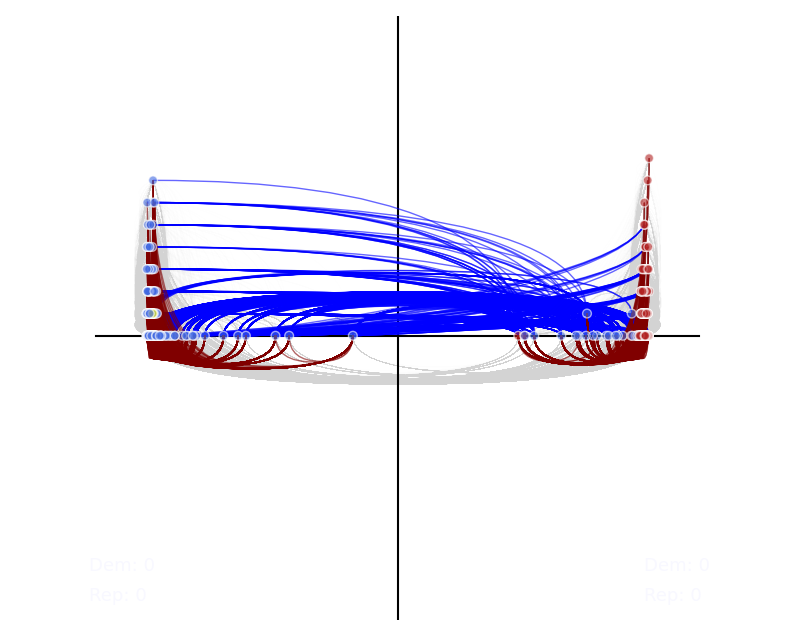

 11%|█         | 4/37 [01:22<11:26, 20.82s/it]

101


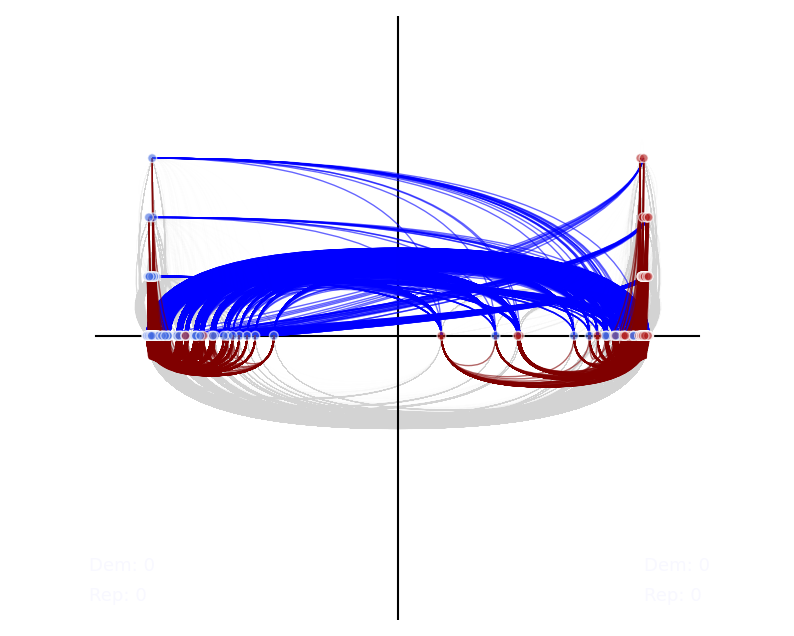

 14%|█▎        | 5/37 [01:44<11:19, 21.23s/it]

99


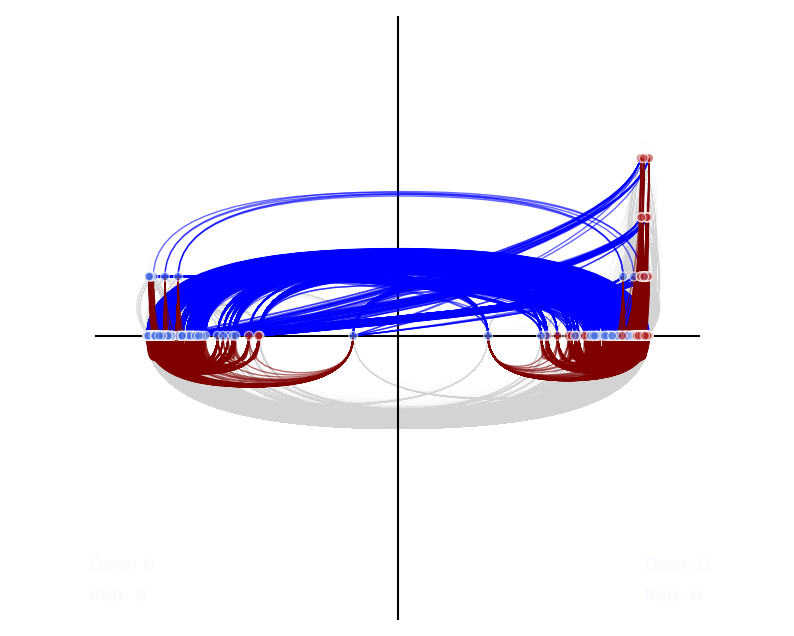

 16%|█▌        | 6/37 [02:05<10:52, 21.06s/it]

83


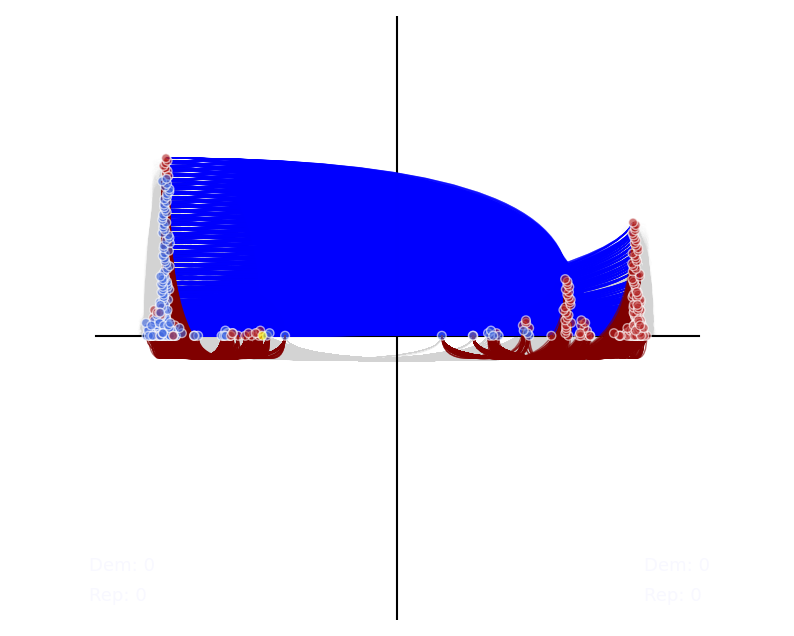

 19%|█▉        | 7/37 [02:23<10:07, 20.24s/it]

92


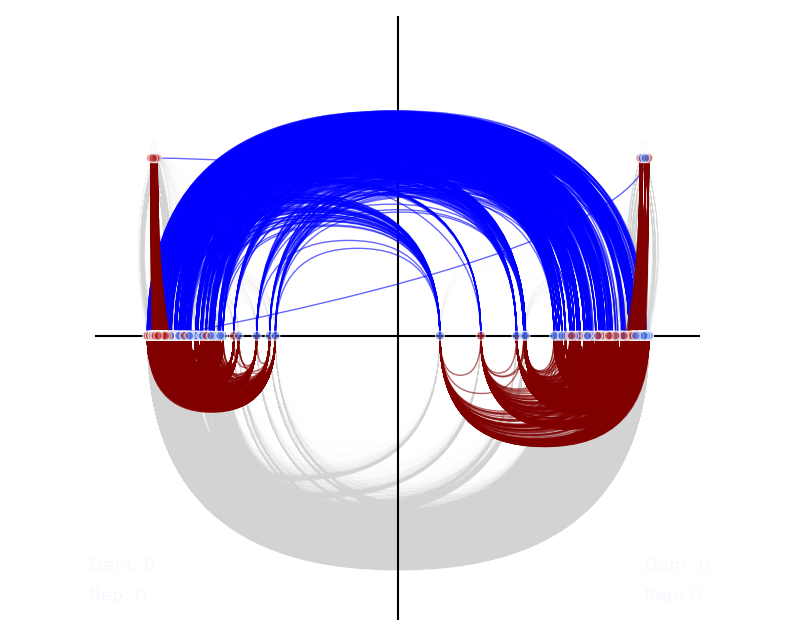

 22%|██▏       | 8/37 [02:46<10:10, 21.06s/it]

107


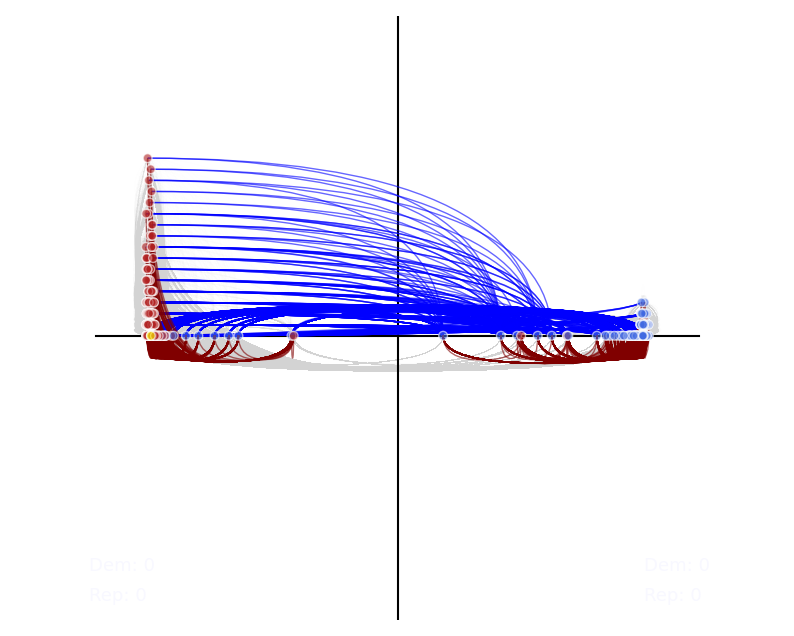

 24%|██▍       | 9/37 [03:09<10:03, 21.56s/it]

103


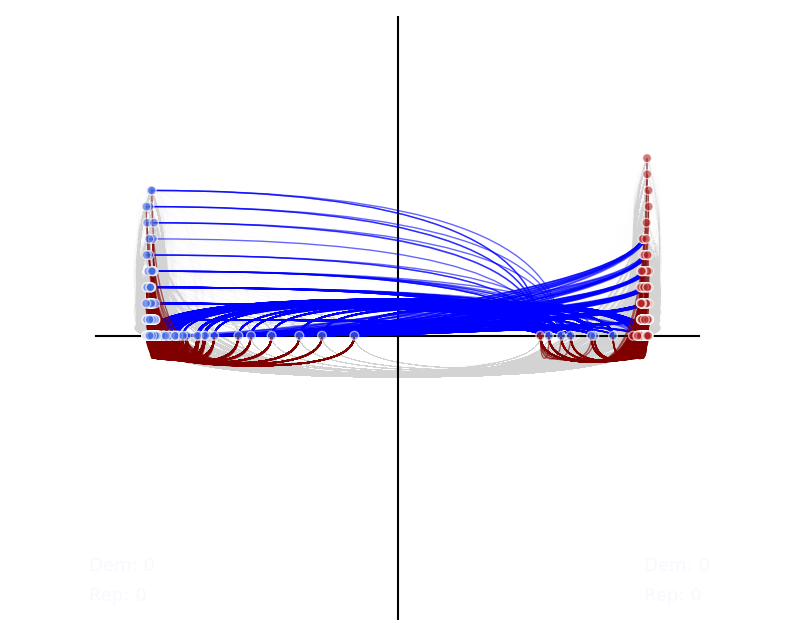

 27%|██▋       | 10/37 [03:31<09:43, 21.62s/it]

78


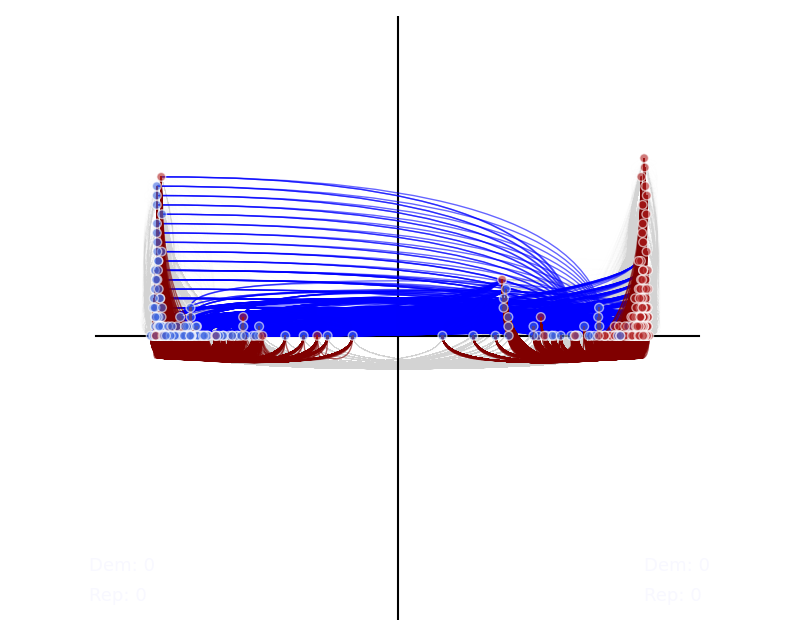

 30%|██▉       | 11/37 [03:52<09:19, 21.52s/it]

87


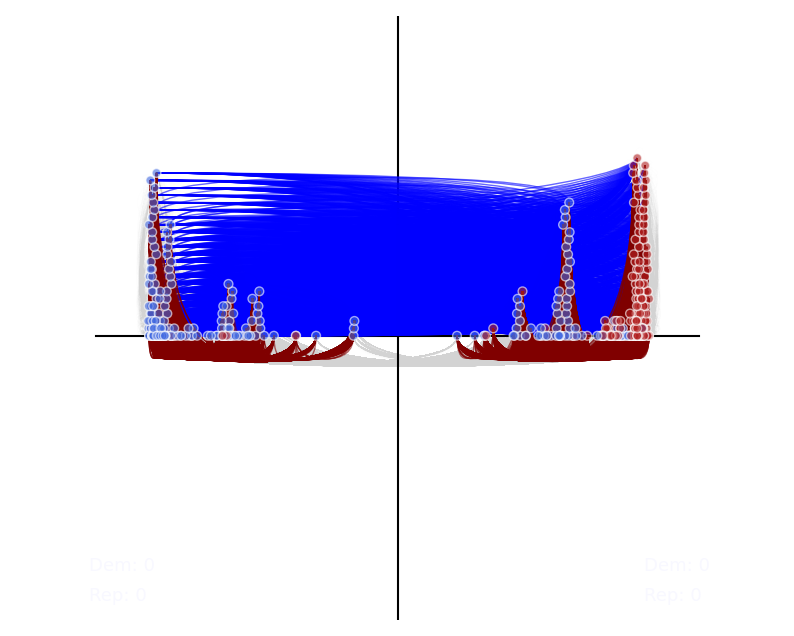

 32%|███▏      | 12/37 [04:12<08:49, 21.20s/it]

110


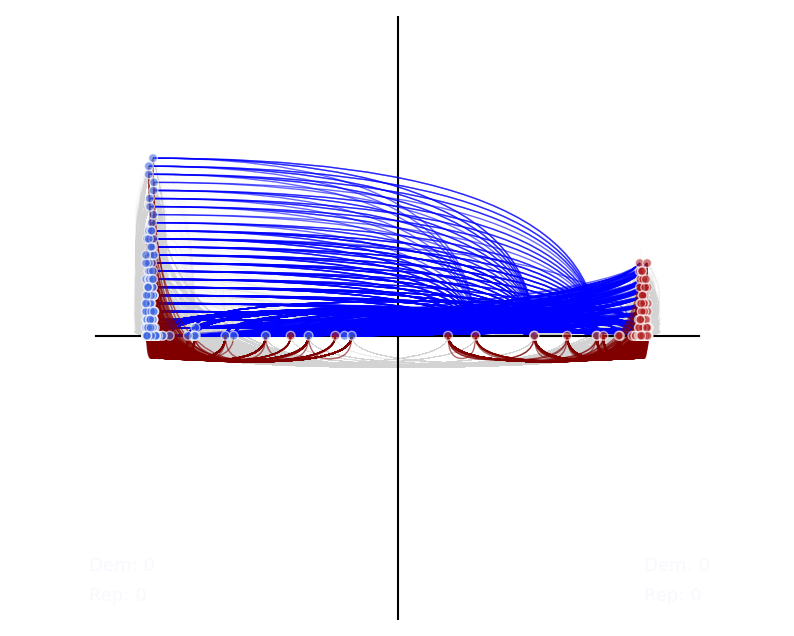

 35%|███▌      | 13/37 [04:34<08:35, 21.49s/it]

100


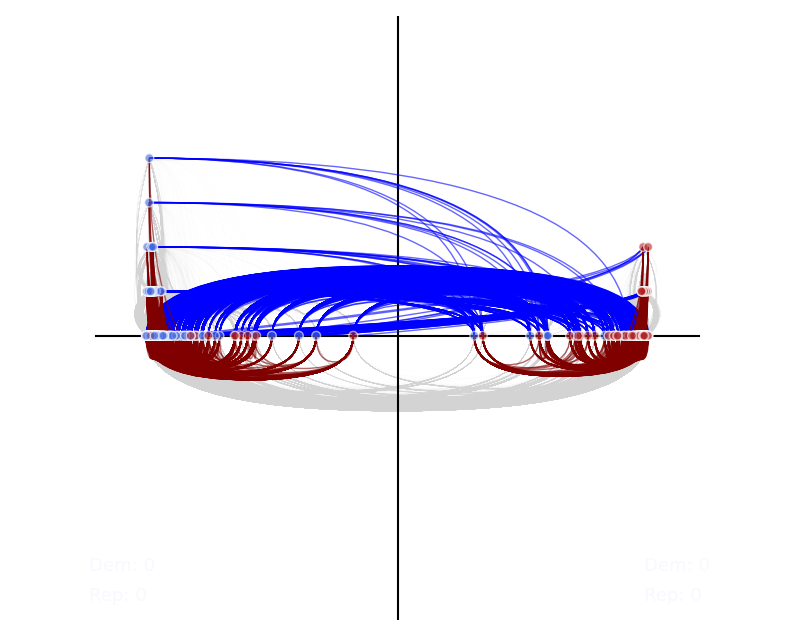

 38%|███▊      | 14/37 [04:56<08:13, 21.47s/it]

95


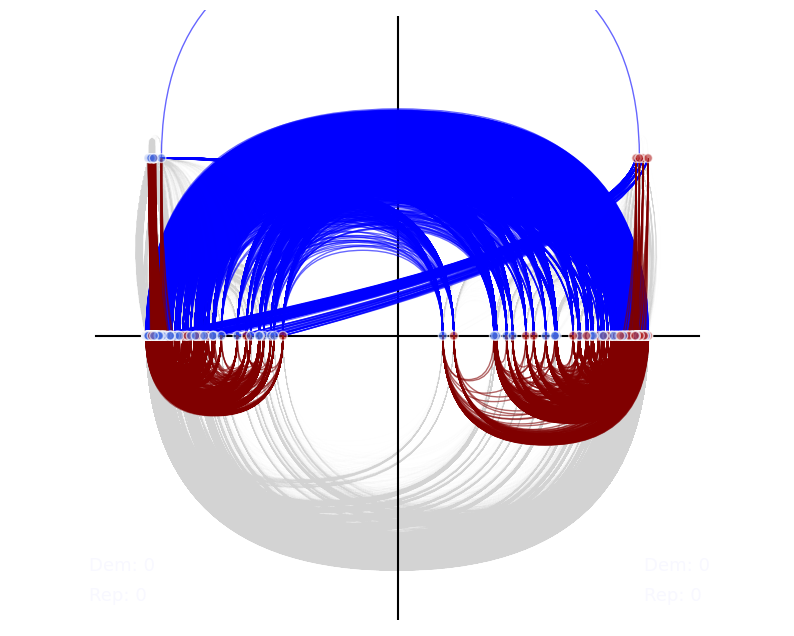

 41%|████      | 15/37 [05:18<07:54, 21.56s/it]

84


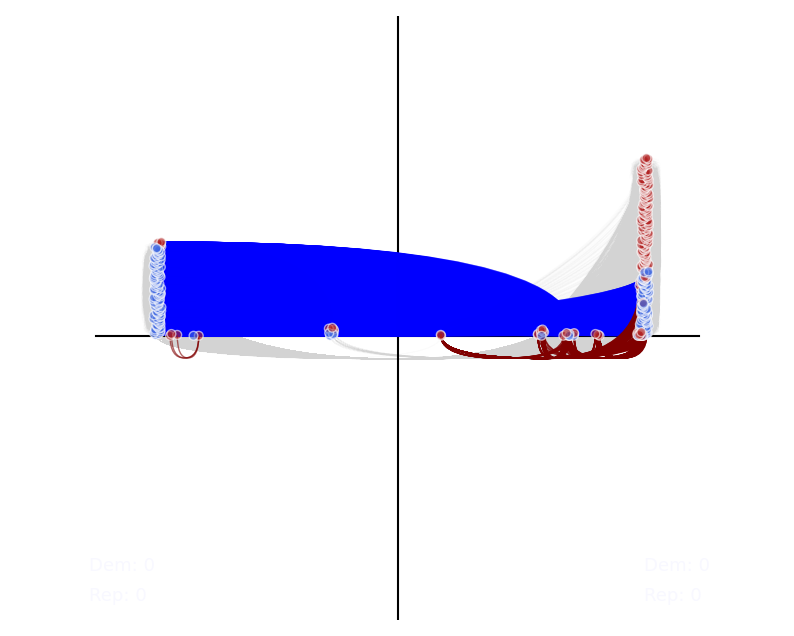

 43%|████▎     | 16/37 [05:36<07:14, 20.70s/it]

85


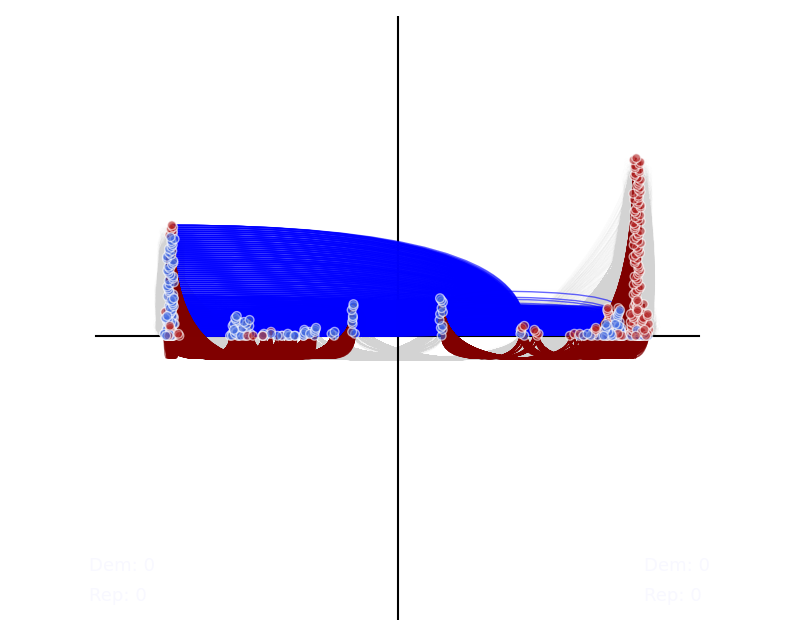

 46%|████▌     | 17/37 [05:56<06:45, 20.25s/it]

98


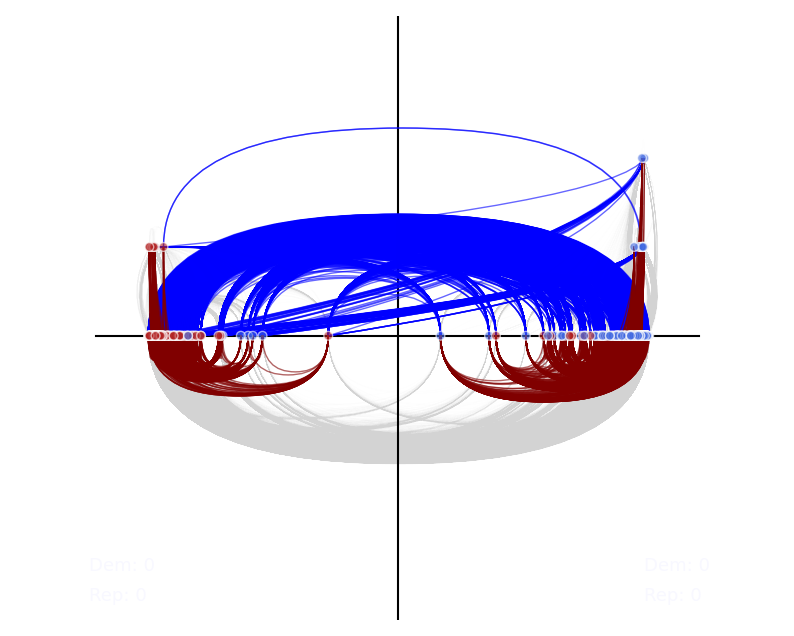

 49%|████▊     | 18/37 [06:16<06:27, 20.40s/it]

105


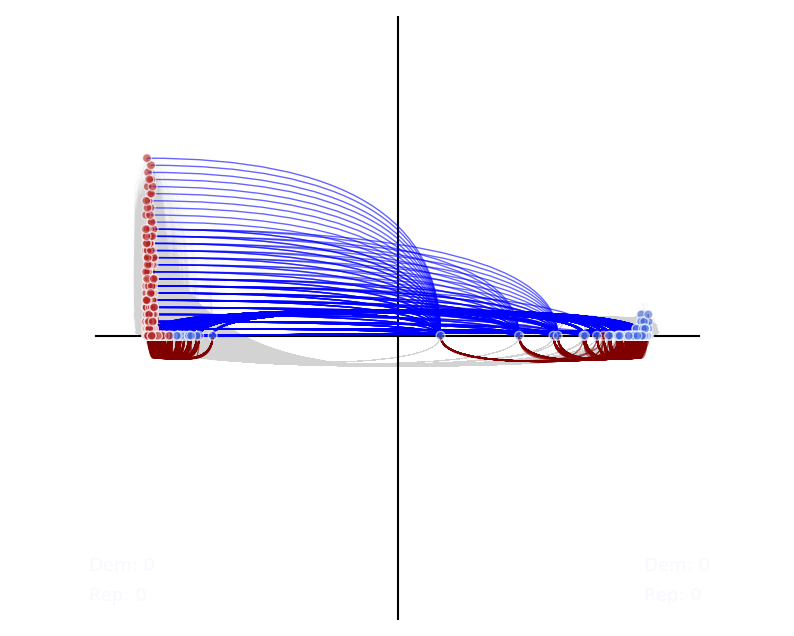

 51%|█████▏    | 19/37 [06:38<06:16, 20.94s/it]

106


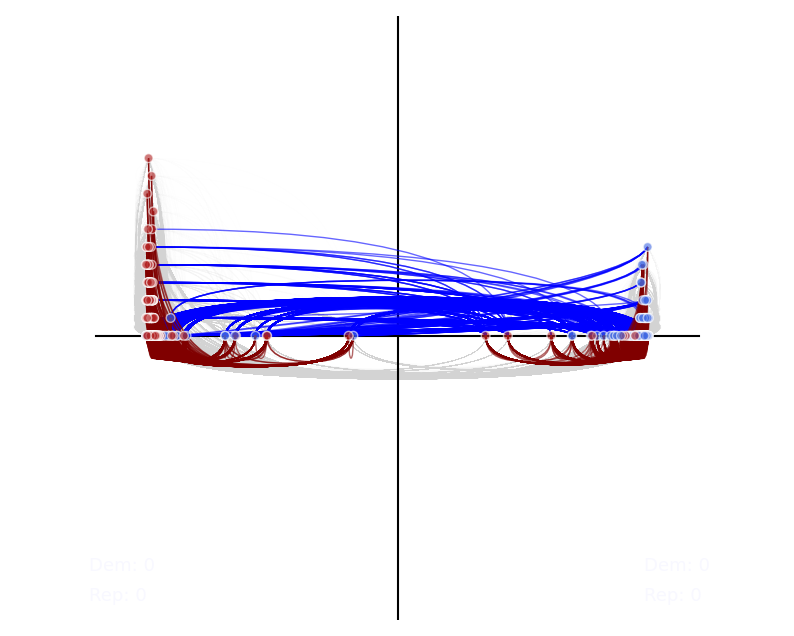

 54%|█████▍    | 20/37 [07:00<05:59, 21.16s/it]

91


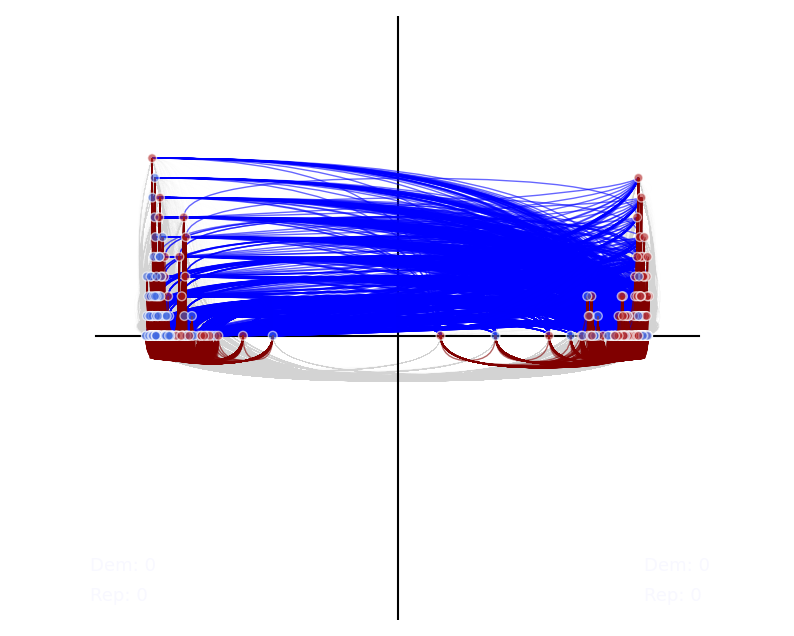

 57%|█████▋    | 21/37 [07:20<05:33, 20.84s/it]

93


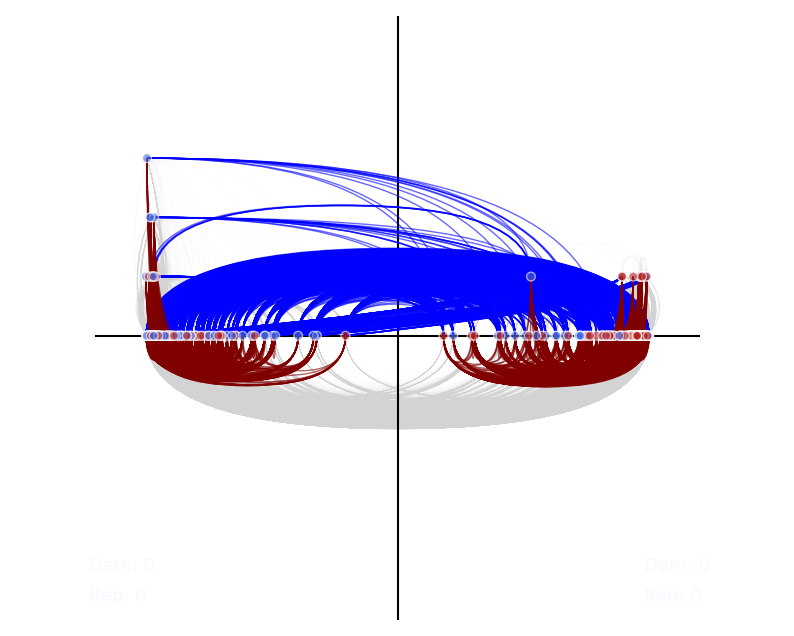

 59%|█████▉    | 22/37 [07:41<05:14, 20.94s/it]

112


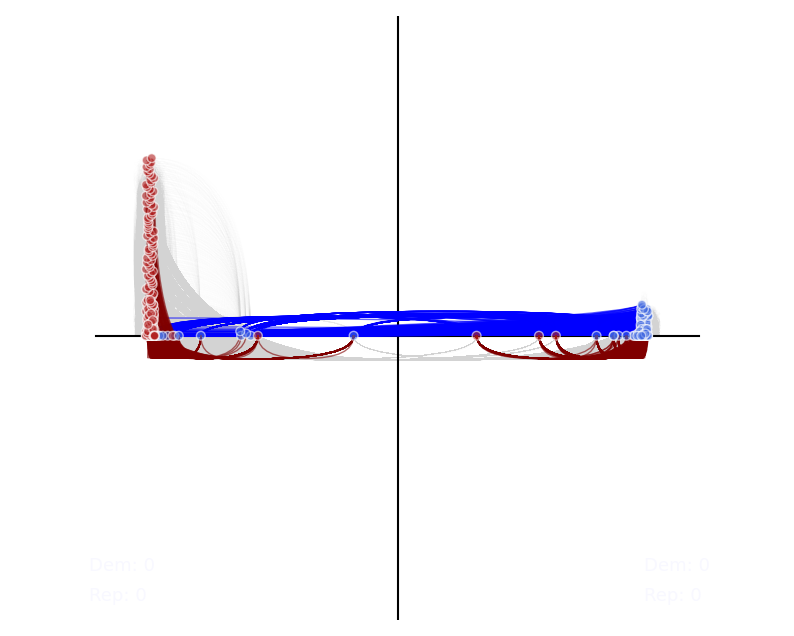

 62%|██████▏   | 23/37 [08:03<04:56, 21.15s/it]

109


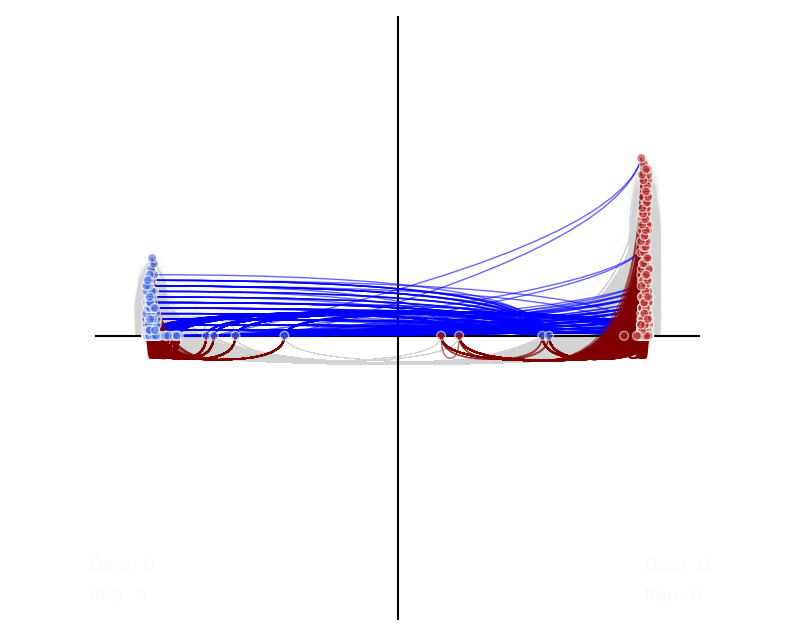

 65%|██████▍   | 24/37 [08:25<04:37, 21.32s/it]

94


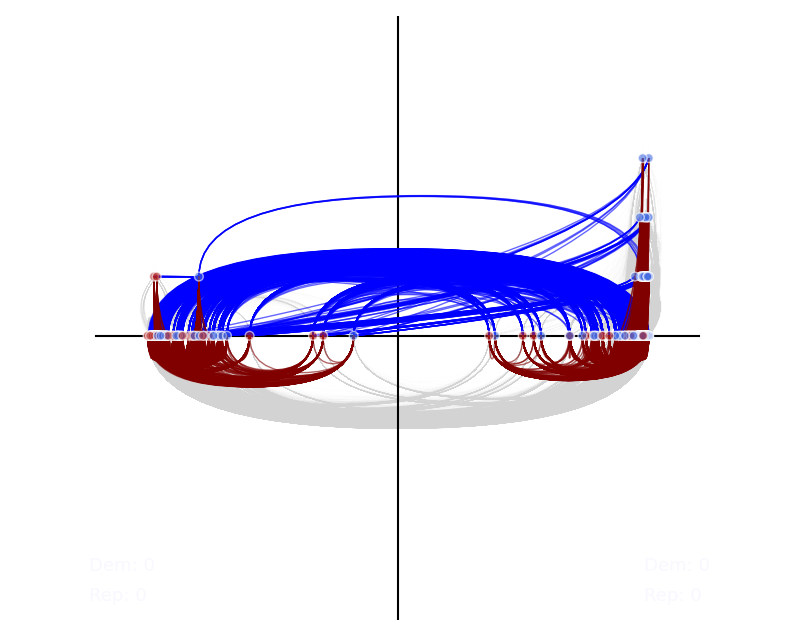

 68%|██████▊   | 25/37 [08:46<04:13, 21.15s/it]

96


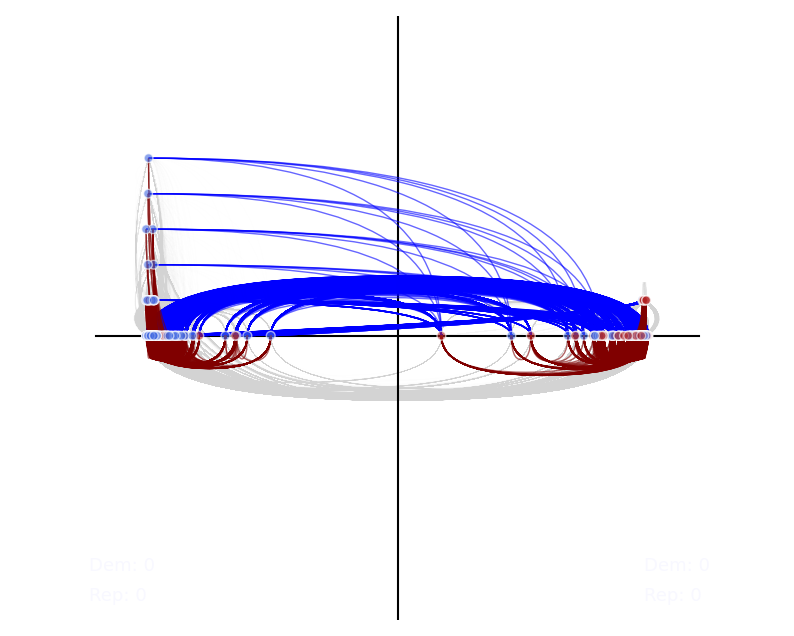

 70%|███████   | 26/37 [09:06<03:51, 21.06s/it]

89


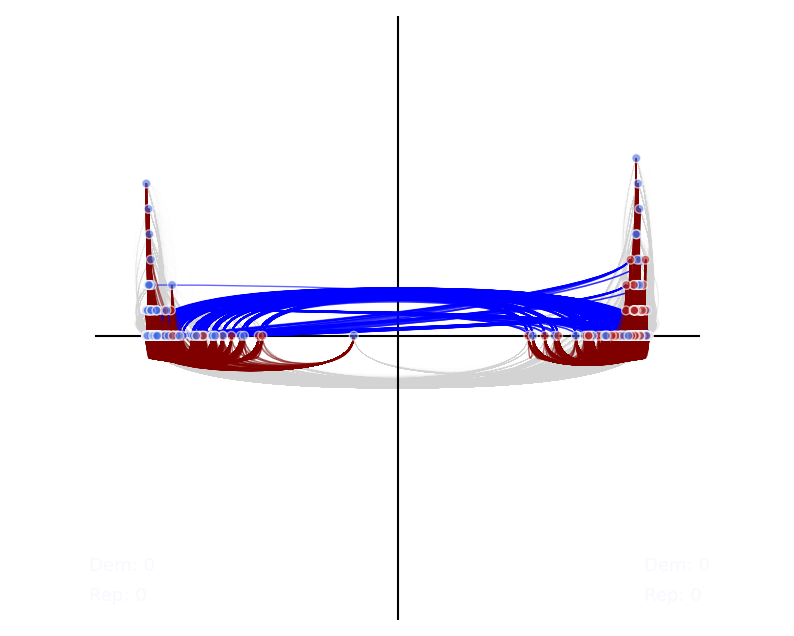

 73%|███████▎  | 27/37 [09:28<03:31, 21.17s/it]

111


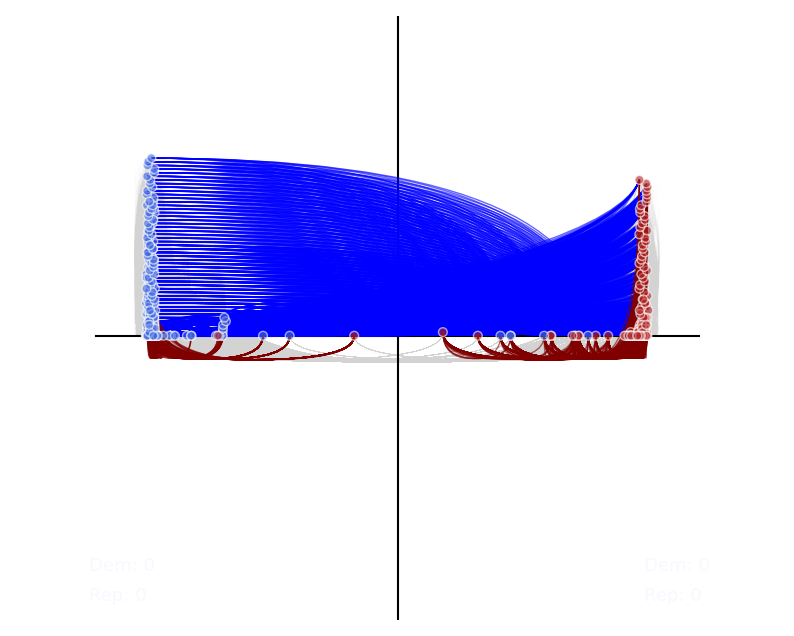

 76%|███████▌  | 28/37 [09:49<03:11, 21.32s/it]

88


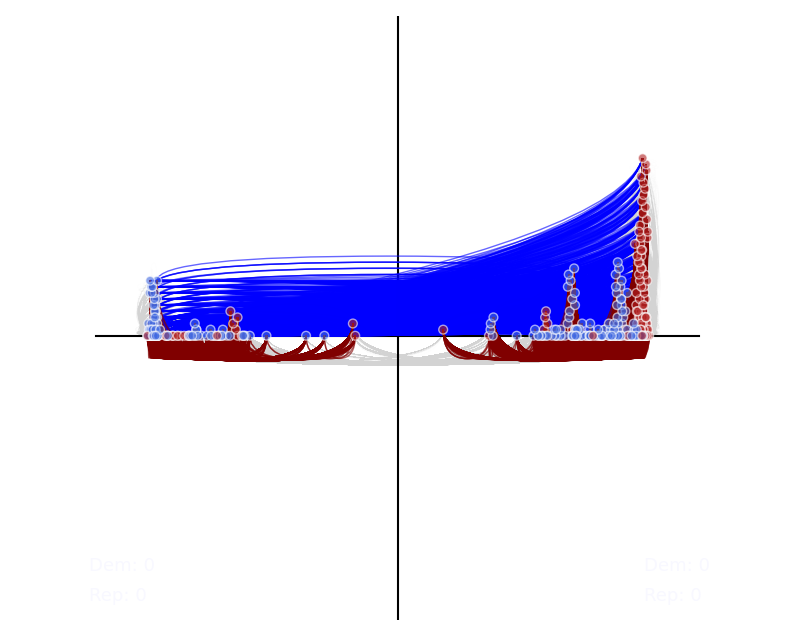

 78%|███████▊  | 29/37 [10:10<02:48, 21.06s/it]

108


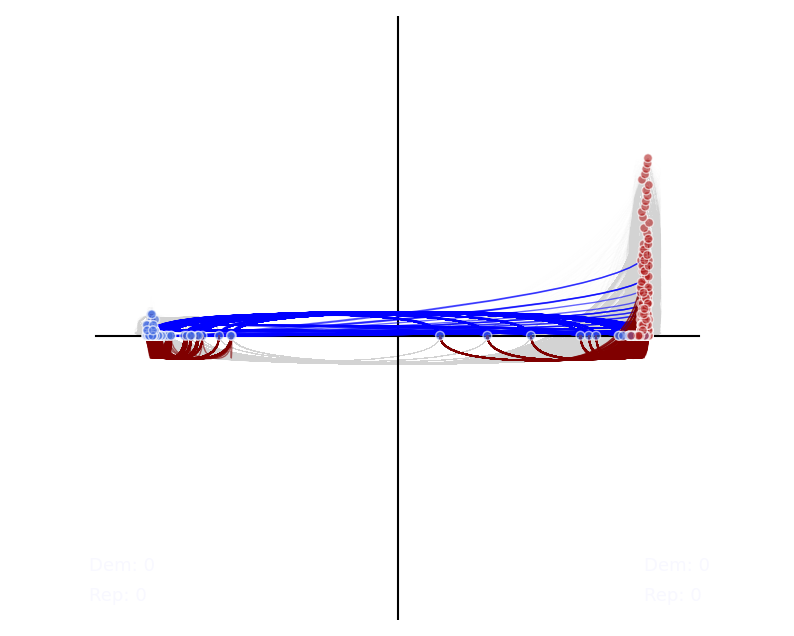

 81%|████████  | 30/37 [10:33<02:31, 21.57s/it]

79


 81%|████████  | 30/37 [10:35<02:28, 21.17s/it]


Exception: Bad input: network G must be connected and undirected.

In [29]:
temp=True
while(temp==True):
	for csv in tqdm(glob.glob(edgelists_path + 'votes_house_clausen_edges/' + 'Civil_Liberties' + '/*.csv')):
		n_congress = int(os.path.basename(csv).replace('congress_', '').replace('.csv', ''))
		print(n_congress)
		temp = pd.read_csv(thresholds_path + 'house_clausen_thresholds/' + 'Civil_Liberties' + '/' + str(n_congress) + '_dic_thresholds_norm.csv')
		threshold_pos = temp.iloc[0]['pos_threshold']
		threshold_neg = temp.iloc[0]['neg_threshold']
		least_eigevalue = read_edgelist('../dataset/edgelists/votes_house_clausen_edges/' + 'Civil_Liberties' + '/congress_' + str(n_congress) + '.csv', threshold_pos, threshold_neg)
		eigenvalues[n_congress] = least_eigevalue

	temp = False

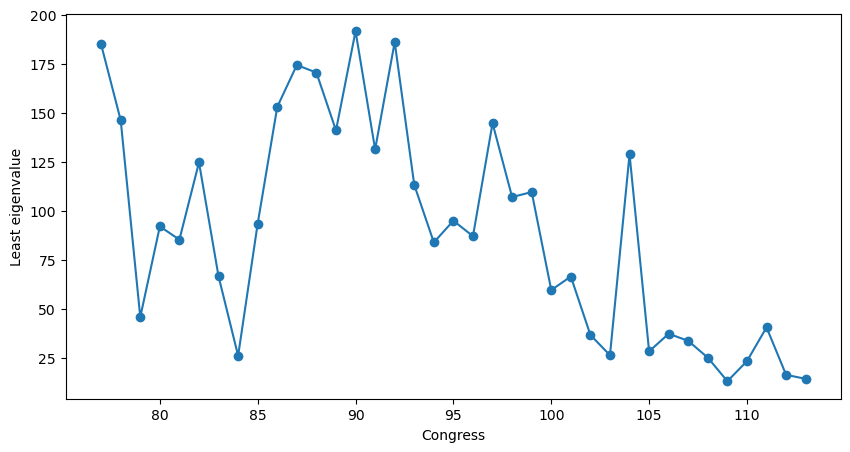

In [27]:
#plot the eigenvalues sorted by congress
plt.figure(figsize=(10, 5))
plt.plot(sorted(eigenvalues.keys()), [eigenvalues[x] for x in sorted(eigenvalues.keys())], 'o-')
plt.xlabel('Congress')
plt.ylabel('Least eigenvalue')
plt.show()
